## MLE Project

Wong Songhan [songhanwong.2020@mitb.smu.edu.sg]

In [386]:
# ! pip3 install kfp --upgrade
# ! pip3 install google-cloud-storage --upgrade
# ! pip3 install --upgrade google-cloud-aiplatform $USER_FLAG
# ! pip3 install xgboost
#! gcloud auth configure-docker asia-east1-docker.pkg.dev
# ! pip3 install -U google-cloud-storage $USER_FLAG
# ! pip3 install $USER kfp google-cloud-pipeline-components --upgrade
! python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"
! python3 -c "import google_cloud_pipeline_components; print('google_cloud_pipeline_components version: {}'.format(google_cloud_pipeline_components.__version__))"

KFP SDK version: 1.8.12
google_cloud_pipeline_components version: 1.0.9


In [387]:
from typing import NamedTuple
from kfp.v2 import dsl
from kfp.v2.dsl import (Artifact, Dataset, Input, InputPath, Model, Output, Metrics,
                        OutputPath, component)
import logging
import os
import kfp
import matplotlib.pyplot as plt


import os
import time
import matplotlib.pyplot as plt
import gc; gc.enable() # memory is tight
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from tensorflow import keras

from skimage.segmentation import mark_boundaries
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.morphology import label
from typing import List
from google.cloud import bigquery, storage
from google.cloud import aiplatform as vertex_ai

import tensorflow as tf
from google_cloud_pipeline_components.experimental.custom_job import utils
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import component

logging.basicConfig(level=logging.INFO)

In [388]:
# Required Parameters, change according to your setups
PROJECT_ID='mle-airbus-detection-smu'
GCS_BUCKET='mle_airbus_dataset'
REGION = 'asia-east1'
ARTIFACT_REGISTRY_REPO="airbus-mle"
#CONTAINER_REGISTRY=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY_REPO}/trainer-xgboost:latest"
CONTAINER_REGISTRY=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY_REPO}/trainer-airbus-model:latest"

In [389]:
GCS_PATH=f"gs://{GCS_BUCKET}"
GCS_TRAIN_IMAGES=f"gs://{GCS_BUCKET}/train_v2/"
MODEL_DISPLAY_NAME="airbus-mle-model"
ENDPOINT_DISPLAY_NAME="airbus-mle-endpoint"
MODEL_DEPLOY_DISPLAY_NAME="airbus-mle-deploy"
TABLE_BQ="mle-airbus-detection-smu.airbus_data.label_data"

In [390]:
TRAIN_IMAGE = "asia-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest"
#does not work with asia docker wat the hell
#DEPLOY_IMAGE = "asia-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-8:latest"
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest"

# Source file URL
source_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
filename = 'data_banknote_authentication.txt'

project_dict = {}
project_dict['PROJECT_ID'] = PROJECT_ID
project_dict['GCS_BUCKET'] = GCS_BUCKET
project_dict['REGION'] = REGION
project_dict['TABLE_BQ'] = TABLE_BQ 

ACCELERATOR_TYPE = 'NVIDIA_TESLA_K80'
MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)
print("Deployment:", DEPLOY_IMAGE)

PIPELINE_NAME = 'airbusmlepipeline'

# Path to various pipeline artifact.
PIPELINE_ROOT = 'gs://{}/{}/pipeline_root'.format(
    GCS_BUCKET, PIPELINE_NAME)

# Paths for users' Python module.
MODULE_ROOT = 'gs://{}/{}/pipeline_module'.format(
    GCS_BUCKET, PIPELINE_NAME)

# Paths for users' data.
DATA_ROOT = 'gs://{}/{}/data'.format(GCS_BUCKET, PIPELINE_NAME)

# This is the path where your model will be pushed for serving.
SERVING_MODEL_DIR = 'gs://{}/{}/serving_model'.format(
    GCS_BUCKET, PIPELINE_NAME)

print('PIPELINE_ROOT: {}'.format(PIPELINE_ROOT))
print('MODULE_ROOT: {}'.format(MODULE_ROOT))
print('DATA_ROOT: {}'.format(DATA_ROOT))
print('SERVING_MODEL_DIR: {}'.format(SERVING_MODEL_DIR))

VERSION = 'v01'
DATASET_DISPLAY_NAME = 'airbus-ship-dataset-display'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{GCS_BUCKET}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')

TENSORBOARD_DISPLAY_NAME = f'tb-{DATASET_DISPLAY_NAME}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}'

Train machine type n1-standard-4
Deploy machine type n1-standard-4
Deployment: us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest
PIPELINE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_root
MODULE_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/pipeline_module
DATA_ROOT: gs://mle_airbus_dataset/airbusmlepipeline/data
SERVING_MODEL_DIR: gs://mle_airbus_dataset/airbusmlepipeline/serving_model


In [391]:
BATCH_SIZE = 16
EDGE_CROP = 16
NB_EPOCHS = 10
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 10
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
N_SAMPLE = 100
IMG_SHAPE = (128, 128)

In [392]:
import google.cloud.aiplatform as aip

aip.init(project=PROJECT_ID, staging_bucket=GCS_BUCKET, location=REGION)
PIPELINE_ROOT = "gs://{}/pipeline_root/mle-project".format(GCS_BUCKET)

## Check if GCS bucket is up

In [11]:
! gsutil ls -al $GCS_PATH

      2373  2022-06-26T04:02:36Z  gs://mle_airbus_dataset/mle-airbus-detection-smu-b1f8ee58e814.json#1656216156596465  metageneration=1
    200808  2022-06-26T14:37:49Z  gs://mle_airbus_dataset/test.parquet#1656254269280477  metageneration=1
   1475293  2022-06-26T14:37:49Z  gs://mle_airbus_dataset/train.parquet#1656254269173283  metageneration=1
                                 gs://mle_airbus_dataset/airbusmlepipeline/
                                 gs://mle_airbus_dataset/pipeline_root/
                                 gs://mle_airbus_dataset/train_v2/
                                 gs://mle_airbus_dataset/trained_model/
TOTAL: 3 objects, 1678474 bytes (1.6 MiB)


# Airbus Image Processing

In [9]:
def rle_decode_tf(mask_rle, shape=(768, 768)):
    
    shape = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    return tf.expand_dims(tf.transpose(tf.reshape(mask_flat, shape)), axis=2)

def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T   # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    #in_mask_list = tf.compat.as_str_any(in_mask_list)
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def merge_rle_encode(mask_rle, shape=(768, 768)):
    img = np.zeros(shape=shape, dtype=np.uint8)
    
    for rle in mask_rle.split(";"):
        img += rle_decode(rle)
        
    return rle_encode(img)

In [10]:
%%bigquery masks

SELECT * FROM `mle-airbus-detection-smu.airbus_data.label_data`

Downloading: 100%|██████████| 231723/231723 [00:01<00:00, 172379.85rows/s]


In [11]:
bqclient = bigquery.Client()

# Download a table.
table = bigquery.TableReference.from_string(
    "mle-airbus-detection-smu.airbus_data.label_data"
)
rows = bqclient.list_rows(
    table
)
df_train = rows.to_dataframe(
    # Optionally, explicitly request to use the BigQuery Storage API. As of
    # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
    # API is used by default.
    create_bqstorage_client=True,
)

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


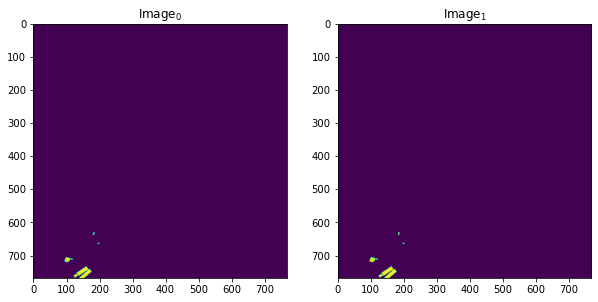

In [12]:
masks = df_train
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels'].values
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

In [13]:
masks = masks[:5000]
masks

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
4,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
4995,0f6f7b46e.jpg,34137 2 34905 4 35672 7 36440 9 37207 13 37975...
4996,0f70520c8.jpg,121892 6 122660 16 123428 26 124196 36 124964 ...
4997,0f71729a2.jpg,447313 9 448081 9 448849 9 449617 9 450385 9 4...
4998,0f735824b.jpg,125965 2 126732 4 127501 3 128269 4 129038 3 1...


In [14]:
masks.replace(to_replace=[None], value='', inplace=True)
masks = masks.groupby(['ImageId'])['EncodedPixels'].apply(lambda x: ';'.join(x) if x is not None else ';'.join('')).reset_index()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [15]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: c_row.count(";"))
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)
masks.EncodedPixels = masks.EncodedPixels.apply(lambda x: merge_rle_encode(x))

In [16]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

1809 training masks
776 validation masks


In [17]:
#rebalance label
from sklearn.utils import resample
#train_df['ships'].hist()

train_df_balanced = pd.DataFrame()
for ship_num in train_df['ships'].unique():
    train_df_balanced = train_df_balanced.append(resample(train_df.query("ships == {}".format(ship_num)), n_samples=N_SAMPLE))

train_df_balanced.reset_index(drop=True, inplace=True)

In [18]:
len(train_df_balanced)

1500

## This segment below to be containerized

In [19]:
import tensorflow as tf
from src.utils.dataset import parse_db_to_img

In [20]:
%%writefile ./src/preprocessing/augment.py
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

class Augment(tf.keras.layers.Layer):
    def __init__(self,  resize_shape=(768, 768), train=True, seed=42):
        super().__init__()
    # both use the same seed, so they'll make the same random changes.
        seed = np.random.randint(1000)
        if train:
            self.augment_inputs = tf.keras.Sequential(
                                    [
                                        layers.experimental.preprocessing.RandomFlip(seed=seed),
                                        layers.experimental.preprocessing.RandomRotation(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomHeight(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomWidth(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomZoom(0.9, seed=seed),
                                        layers.experimental.preprocessing.Rescaling(1.0 / 255),
                                        layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                    ]
                                )

            self.augment_labels = tf.keras.Sequential(
                                    [
                                        layers.experimental.preprocessing.RandomFlip(seed=seed),
                                        layers.experimental.preprocessing.RandomRotation(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomHeight(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomWidth(0.1, seed=seed),
                                        layers.experimental.preprocessing.RandomZoom(0.9, seed=seed),
                                        layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                    ]
                                )
        else:
            self.augment_inputs = tf.keras.Sequential(
                                    [
                                        layers.experimental.preprocessing.Rescaling(1.0 / 255),
                                        layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                    ]
                                )

            self.augment_labels = tf.keras.Sequential(
                                    [
                                        layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                    ]
                                )       

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

Overwriting ./src/preprocessing/augment.py


In [20]:
from src.preprocessing.augment import Augment

dataset = tf.data.Dataset.from_tensor_slices((train_df_balanced['ImageId'].values, train_df_balanced['EncodedPixels'].values))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.map(lambda x, y: parse_db_to_img(GCS_TRAIN_IMAGES + x, y))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.map(Augment(resize_shape=IMG_SHAPE, train=True))
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

validation = tf.data.Dataset.from_tensor_slices((valid_df['ImageId'].values, valid_df['EncodedPixels'].values))
validation = validation.shuffle(buffer_size=10)
validation = validation.map(lambda x, y: parse_db_to_img(GCS_TRAIN_IMAGES + x, y))
validation = validation.batch(BATCH_SIZE)
validation = validation.map(Augment(resize_shape=IMG_SHAPE, train=False))
validation = validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

2022-06-27 01:42:46.214207: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2022-06-27 01:42:58.667106: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


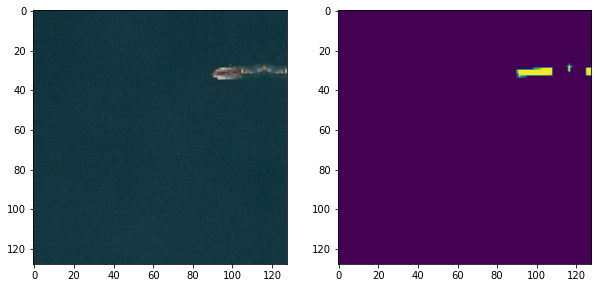

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
for images, labels in dataset.take(1):
    images = images[0]
    labels = labels[0]
    ax[0] = ax[0].imshow(images)
    ax[1] = ax[1].imshow(labels)

In [25]:
from src.models.u_net import UNet_keras
seg_model = UNet_keras(edge_crop=EDGE_CROP, upsample_mode=UPSAMPLE_MODE, img_shape=IMG_SHAPE)

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,BinaryCrossentropy 

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.ctph".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=10, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=30) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, reduceLROnPlat, early]

step_count = min(MAX_TRAIN_STEPS, train_df_balanced.shape[0]//BATCH_SIZE)
loss_history = [seg_model.fit(dataset, 
                             epochs=NB_EPOCHS, 
                             validation_data=validation.take(1),
                             callbacks=callbacks_list,
                              verbose=1,
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/10
42/94 [============>.................] - ETA: 2:45 - loss: 4.0272e-04 - dice_coef: 0.0137 - binary_accuracy: 0.9134 - true_positive_rate: 0.0915

KeyboardInterrupt: 

In [28]:
fig, axs = plt.subplots(BATCH_SIZE, 2, figsize=(10, 100))

preview = dataset
break
for images, labels in preview.take(1):
    for i in range(BATCH_SIZE):
        ax = axs[i]
        image = images[i]
        label = labels[i]
        ax[0] = ax[0].imshow(image)
        ax[1] = ax[1].imshow(seg_model.predict(preview.take(1))[i])


SyntaxError: 'break' outside loop (249240107.py, line 7)

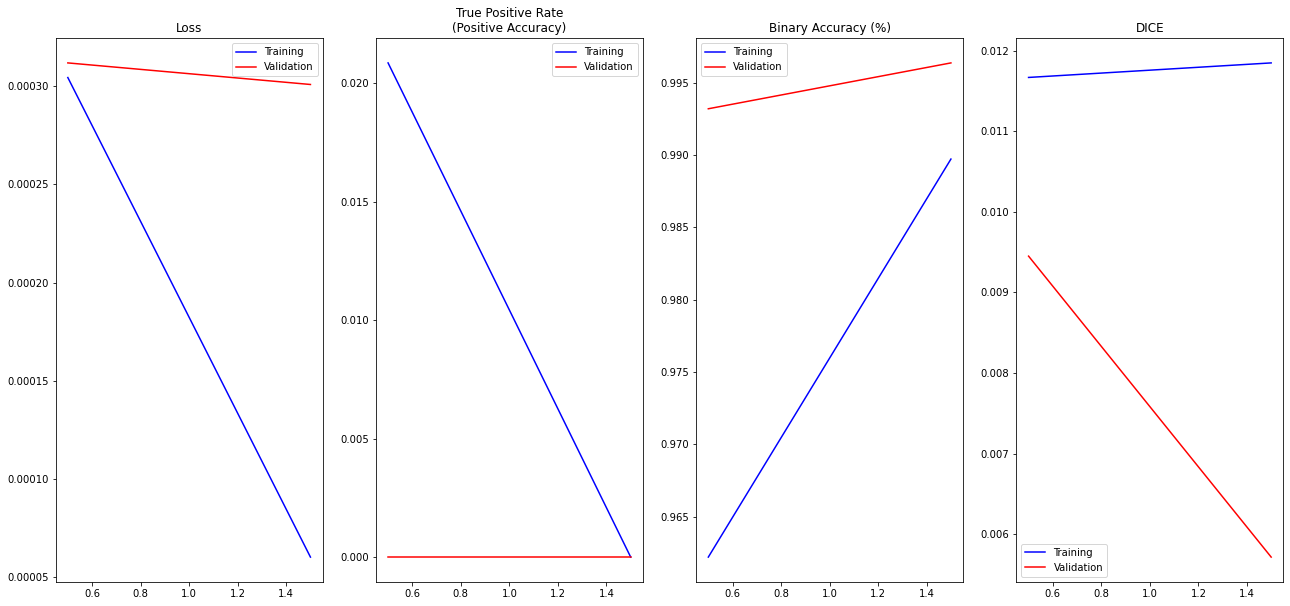

In [237]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

## Data ingest/Processing Component 

## TODO: Please convert this to docker format, very messy to use Python component

In [145]:
@component(packages_to_install=["google-cloud-storage", "google-cloud-bigquery", "tensorflow", 
                                "sklearn", "pandas", "scikit-image", "db-dtypes", "google-auth",
                               "fsspec", "pyarrow"],
           output_component_file="import_file_component.yaml",)
def import_file_component(
    project_dict: dict
    ) -> NamedTuple(
    "Outputs",
    [
        ("train_data_fpath", str),  # Return parameter.
        ("test_data_fpath", str),  # Return generic Artifact.
    ],
    ):

    import requests
    import os
    import logging
    from sklearn.utils import resample
    from google.cloud import bigquery, storage
    import pandas as pd
    import numpy as np
    import tensorflow as tf
    from google.oauth2 import service_account
    from skimage.segmentation import mark_boundaries
    from skimage.util import montage as montage2d
    from skimage.io import imread
    from skimage.segmentation import mark_boundaries
    from skimage.util import montage
    from skimage.morphology import label

    #TODO: How to improve these functions ?
    def rle_decode_tf(mask_rle, shape=(768, 768)):

        shape = tf.convert_to_tensor(shape, tf.int64)
        size = tf.math.reduce_prod(shape)
        # Split string
        s = tf.strings.split(mask_rle)
        s = tf.strings.to_number(s, tf.int64)
        # Get starts and lengths
        starts = s[::2] - 1
        lens = s[1::2]
        # Make ones to be scattered
        total_ones = tf.reduce_sum(lens)
        ones = tf.ones([total_ones], tf.uint8)
        # Make scattering indices
        r = tf.range(total_ones)
        lens_cum = tf.math.cumsum(lens)
        s = tf.searchsorted(lens_cum, r, 'right')
        idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
        # Scatter ones into flattened mask
        mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
        return tf.expand_dims(tf.transpose(tf.reshape(mask_flat, shape)), axis=2)

    def multi_rle_encode(img):
        labels = label(img[:, :, 0])
        return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

    # ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
    def rle_encode(img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        pixels = img.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

    def rle_decode(mask_rle, shape=(768, 768)):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, 1 - mask, 0 - background
        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape).T   # Needed to align to RLE direction

    def masks_as_image(in_mask_list):
        #in_mask_list = tf.compat.as_str_any(in_mask_list)
        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768), dtype = np.int16)
        #if isinstance(in_mask_list, list):
        for mask in in_mask_list:
            if isinstance(mask, str):
                all_masks += rle_decode(mask)
        return np.expand_dims(all_masks, -1)

    def merge_rle_encode(mask_rle, shape=(768, 768)):
        img = np.zeros(shape=shape, dtype=np.uint8)

        for rle in mask_rle.split(";"):
            img += rle_decode(rle)

        return rle_encode(img)

    def parse_db_to_img(filename, label):
        file_path = filename
        img = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(img, channels=3)
        label_img = rle_decode_tf(label)

        return image, label_img
    
    BATCH_SIZE = 16
    EDGE_CROP = 16
    NB_EPOCHS = 10
    GAUSSIAN_NOISE = 0.1
    UPSAMPLE_MODE = 'SIMPLE'
    # downsampling inside the network
    NET_SCALING = None
    # downsampling in preprocessing
    IMG_SCALING = (1, 1)
    # number of validation images to use
    VALID_IMG_COUNT = 10
    # maximum number of steps_per_epoch in training
    MAX_TRAIN_STEPS = 200
    AUGMENT_BRIGHTNESS = False
    N_SAMPLE = 100
    IMG_SHAPE = (128, 128)

    PROJECT_ID = project_dict['PROJECT_ID']
    GCS_BUCKET = project_dict['GCS_BUCKET']
    REGION = project_dict['REGION']
    TABLE_BQ = project_dict['TABLE_BQ']
    
    bucket = storage.Client().bucket(GCS_BUCKET)


    try: 
        bqclient = bigquery.Client(project=PROJECT_ID, location=REGION)
        logging.info("No authentication required!")
    except:
        logging.info("Try a hacky way")
        blob = bucket.blob("mle-airbus-detection-smu-b1f8ee58e814.json")
        blob.download_to_filename("mle-airbus-detection-smu-b1f8ee58e814.json")
        credentials = service_account.Credentials.from_service_account_file(
            "mle-airbus-detection-smu-b1f8ee58e814.json", scopes=["https://www.googleapis.com/auth/cloud-platform"],
        )

        bqclient = bigquery.Client(credentials=credentials, project=PROJECT_ID, location=REGION)
        logging.info("Authenticated!")

    # Download a table.
    table = bigquery.TableReference.from_string(
        #TODO: replace with param
        "mle-airbus-detection-smu.airbus_data.label_data"
    )
    rows = bqclient.list_rows(
        table
    )
    masks = rows.to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
    
    #TODO: parame
    masks = masks[:20000]
    masks.replace(to_replace=[None], value='', inplace=True)
    masks = masks.groupby(['ImageId'])['EncodedPixels'].apply(lambda x: ';'.join(x) if x is not None else ';'.join('')).reset_index()
    
    masks['ships'] = masks['EncodedPixels'].map(lambda c_row: c_row.count(";"))
    unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
    unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
    unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
    masks.drop(['ships'], axis=1, inplace=True)
    unique_img_ids.sample(5)
    masks.EncodedPixels = masks.EncodedPixels.apply(lambda x: merge_rle_encode(x))
    
    from sklearn.model_selection import train_test_split
    train_ids, valid_ids = train_test_split(unique_img_ids, 
                     test_size = 0.3, 
                     stratify = unique_img_ids['ships'])
    train_df = pd.merge(masks, train_ids)
    valid_df = pd.merge(masks, valid_ids)
    print(train_df.shape[0], 'training masks')
    print(valid_df.shape[0], 'validation masks')
    
    train_df_balanced = pd.DataFrame()
    for ship_num in train_df['ships'].unique():
        train_df_balanced = train_df_balanced.append(resample(train_df.query("ships == {}".format(ship_num)), n_samples=N_SAMPLE))
    train_df_balanced.reset_index(drop=True, inplace=True)

    valid_df_balanced = pd.DataFrame()
    for ship_num in valid_df['ships'].unique():
        valid_df_balanced = valid_df_balanced.append(resample(valid_df.query("ships == {}".format(ship_num)), n_samples=N_SAMPLE//10))

    #TODO: make this nicer , don't hard code
    train_df_balanced.to_parquet(f"train.parquet")
    valid_df_balanced.to_parquet(f"test.parquet")
    
    blob = bucket.blob('train.parquet')
    blob.upload_from_filename('train.parquet')
    blob = bucket.blob('test.parquet')
    blob.upload_from_filename('test.parquet')
    
    #return f"gs://{GCS_BUCKET}/train.parquet", f"gs://{GCS_BUCKET}/test.parquet"
    return f"gs://{GCS_BUCKET}/train.parquet", f"gs://{GCS_BUCKET}/test.parquet"

## TODO: Testing for Data ingest/Processing Component 

In [13]:
@component(packages_to_install=["google-cloud-storage"],
           output_component_file="test_file_component.yaml",)
def test_file_component(
    project_dict: dict,
    gcp_file_url: str
    ) -> str:
    
    import os
    import logging
    from google.cloud import storage
    
    PROJECT_ID = project_dict['PROJECT_ID']
    GCS_BUCKET = project_dict['GCS_BUCKET']
    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.get_bucket(GCS_BUCKET)
    blob = bucket.get_blob(gcp_file_url.split(GCS_BUCKET)[-1][1::])

    filesize = 46400
    
    assert blob.size == filesize, logging.error("File size is incorrect")
    
    logging.info("File size is correct.")
    
    return gcp_file_url

# Model Evaluation

In [14]:
from kfp.v2.dsl import ClassificationMetrics, Metrics, Output, component

@component(
    packages_to_install=["tensorflow", "numpy", "pandas", "google-cloud-storage", "fsspec", "pyarrow"],
    base_image="python:3.7",
    output_component_file="model_eval_component.yaml")
def model_eval_component(
    test_filepath: str,
    model_filepath: str,
    metrics: Output[Metrics]
):
    import tensorflow.keras.backend as K
    import tensorflow as tf
    import numpy as np
    import pandas as pd
    from tensorflow.keras import layers
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.losses import binary_crossentropy,BinaryCrossentropy 
    from google.cloud import storage


    class Augment(tf.keras.layers.Layer):
        def __init__(self,  resize_shape=(768, 768), train=True, seed=42):
            super().__init__()
        # both use the same seed, so they'll make the same random changes.
            seed = np.random.randint(1000)
            if train:
                self.augment_inputs = tf.keras.Sequential(
                                        [
                                            layers.experimental.preprocessing.RandomFlip(seed=seed),
                                            layers.experimental.preprocessing.RandomRotation(0.1, seed=seed),
                                            layers.experimental.preprocessing.RandomHeight(0.1, seed=seed),
                                            layers.experimental.preprocessing.RandomWidth(0.1, seed=seed),
                                            layers.experimental.preprocessing.RandomZoom(0.9, seed=seed),
                                            layers.experimental.preprocessing.Rescaling(1.0 / 255),
                                            layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                        ]
                                    )

                self.augment_labels = tf.keras.Sequential(
                                        [
                                            layers.experimental.preprocessing.RandomFlip(seed=seed),
                                            layers.experimental.preprocessing.RandomRotation(0.1, seed=seed),
                                            layers.experimental.preprocessing.RandomHeight(0.1, seed=seed),
                                            layers.experimental.preprocessing.RandomWidth(0.1, seed=seed),
                                            layers.experimental.preprocessing.RandomZoom(0.9, seed=seed),
                                            layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                        ]
                                    )
            else:
                self.augment_inputs = tf.keras.Sequential(
                                        [
                                            layers.experimental.preprocessing.Rescaling(1.0 / 255),
                                            layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                        ]
                                    )

                self.augment_labels = tf.keras.Sequential(
                                        [
                                            layers.experimental.preprocessing.Resizing(resize_shape[0], resize_shape[0])
                                        ]
                                    )       

        def call(self, inputs, labels):
            inputs = self.augment_inputs(inputs)
            labels = self.augment_labels(labels)
            return inputs, labels
    
    def dice_coef(y_true, y_pred, smooth=1):
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
        return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

    def dice_p_bce(in_gt, in_pred):
        return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

    def true_positive_rate(y_true, y_pred):
        return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
    
    #TODO: How to improve these functions ?
    def rle_decode_tf(mask_rle, shape=(768, 768)):

        shape = tf.convert_to_tensor(shape, tf.int64)
        size = tf.math.reduce_prod(shape)
        # Split string
        s = tf.strings.split(mask_rle)
        s = tf.strings.to_number(s, tf.int64)
        # Get starts and lengths
        starts = s[::2] - 1
        lens = s[1::2]
        # Make ones to be scattered
        total_ones = tf.reduce_sum(lens)
        ones = tf.ones([total_ones], tf.uint8)
        # Make scattering indices
        r = tf.range(total_ones)
        lens_cum = tf.math.cumsum(lens)
        s = tf.searchsorted(lens_cum, r, 'right')
        idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
        # Scatter ones into flattened mask
        mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
        return tf.expand_dims(tf.transpose(tf.reshape(mask_flat, shape)), axis=2)

    def multi_rle_encode(img):
        labels = label(img[:, :, 0])
        return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

    # ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
    def rle_encode(img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        pixels = img.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

    def rle_decode(mask_rle, shape=(768, 768)):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, 1 - mask, 0 - background
        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape).T   # Needed to align to RLE direction

    def masks_as_image(in_mask_list):
        #in_mask_list = tf.compat.as_str_any(in_mask_list)
        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768), dtype = np.int16)
        #if isinstance(in_mask_list, list):
        for mask in in_mask_list:
            if isinstance(mask, str):
                all_masks += rle_decode(mask)
        return np.expand_dims(all_masks, -1)

    def merge_rle_encode(mask_rle, shape=(768, 768)):
        img = np.zeros(shape=shape, dtype=np.uint8)

        for rle in mask_rle.split(";"):
            img += rle_decode(rle)

        return rle_encode(img)

    def parse_db_to_img(filename, label):
        file_path = filename
        img = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(img, channels=3)
        label_img = rle_decode_tf(label)

        return image, label_img

    IMG_SHAPE=(128,128)
    GCS_BUCKET="mle_airbus_dataset"
    BATCH_SIZE = 16
    EDGE_CROP = 16
    NB_EPOCHS = 10
    GAUSSIAN_NOISE = 0.1
    UPSAMPLE_MODE = 'SIMPLE'
    # downsampling inside the network
    NET_SCALING = None
    # downsampling in preprocessing
    IMG_SCALING = (1, 1)
    # number of validation images to use
    VALID_IMG_COUNT = 10
    # maximum number of steps_per_epoch in training
    MAX_TRAIN_STEPS = 200
    AUGMENT_BRIGHTNESS = False
    N_SAMPLE = 100
    bucket = storage.Client().bucket(GCS_BUCKET)

    blob = bucket.blob("test.parquet")
    blob.download_to_filename("test.parquet")

    valid_df = pd.read_parquet(f"test.parquet")
    validation = tf.data.Dataset.from_tensor_slices((valid_df['ImageId'].values, valid_df['EncodedPixels'].values))
    validation = validation.shuffle(buffer_size=10)
    validation = validation.map(lambda x, y: parse_db_to_img("gs://mle_airbus_dataset/train_v2/" + x, y))
    validation = validation.batch(BATCH_SIZE)
    validation = validation.map(Augment(resize_shape=IMG_SHAPE, train=False))
    validation = validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    model_eval = tf.keras.models.load_model(f'gs://{GCS_BUCKET}/trained_model/segm_full_200_20220626-143859/', compile=False)
    model_eval.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
    result = model_eval.evaluate(validation)
    metrics.log_metric("dice_coef", (result[1]))
    metrics.log_metric("binary_accuracy", (result[2]))
    metrics.log_metric("true_positive_rate", (result[3]))
    

## Model Evaluation Unit Test

In [15]:
@component(
    base_image="python:3.7",
    output_component_file="model_eval_test_component.yaml")
def model_eval_test_component(
    metrics: Input[Metrics]
):
    import logging
    
    metrics_thresholds = {
        'dice_coef': 0.1,
        'binary_accuracy': 0.8,
        'true_positive_rate': 0.3
    }
    
    for k, v in metrics.metadata.items():
        assert v >= metrics_thresholds[k]
        logging.info(f"{k}:{v}, threshold: {metrics_thresholds[k]}. Passed.")


In [193]:
%%writefile tf-trainer.py
import pandas as pd
import datetime
import argparse
import logging
import os
import sys
from xgboost import XGBClassifier
from google.cloud import storage

logging.basicConfig(level=logging.INFO)

parser = argparse.ArgumentParser()
parser.add_argument('--input_url', dest='input_url',
                    default='', type=str,
                    help='Input csv url')
parser.add_argument('--gcs_url', dest='gcs_url',
                    default='', type=str,
                    help='GCS bucket url')
parser.add_argument('--n_estimator', dest='n_estimator',
                    default=50, type=int,
                    help='Number of boosting rounds.')
parser.add_argument('--output', dest='output',
                    default=datetime.datetime.now().strftime('%Y%m%d_%H%M'), type=str,
                    help='Name of output folder')
args = parser.parse_args()


logging.info('Python Version = {}'.format(sys.version))
gcp_file_url = args.input_url
gcs_bucket = args.gcs_url
bucket = storage.Client().bucket(gcs_bucket)

try:
    df = pd.read_csv(gcp_file_url, header=None)
    logging.info(f"Loading of dataframe from {gcp_file_url} is successful.")
except:
    logging.error(f"Error loading dataframe from {gcp_file_url}")

x, y = df.iloc[:,:4], df.iloc[:,4]

model = XGBClassifier()
model.fit(x, y)
model_filename = "model.bst"
model.save_model(model_filename)

try:
    blob = bucket.blob('assignment2/{}/{}'.format(args.output,
        model_filename))
    blob.upload_from_filename(model_filename)
    model_path = f"gs://{gcs_bucket}/{blob.name}"
    logging.info(f"Uploading of model filename to {model_path} is successful.")
except:
    logging.error(f"Uploading of model filename to {model_path} is failed!")

with open('./output.txt', 'w') as f:
    logging.info(f"Model path url is in {'./output.txt'}")
    f.write(model_path)

Overwriting tf-trainer.py


## Create a docker file

In [390]:
%%writefile Dockerfile
FROM asia-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest
WORKDIR /app
COPY ./src ./src
COPY tf-trainer.py ./app/tf-trainer.py
ENTRYPOINT ["python","./app/tf-trainer.py"]

Overwriting Dockerfile


## Write Component Definition File

In [391]:
%%bash -s "{CONTAINER_REGISTRY}"

CONTAINER_REGISTRY=$1
echo ${CONTAINER_REGISTRY}
# Create the component definition .yaml file
cat > tensorflow_airbus.yaml <<HERE
name: Tensorflow Airbus Model Training
description: Train a tf model and save to GCS
inputs:
  - name: input_url
    description: 'Input csv url.'
    type: String
  - name: gcs_url
    description: 'GCS bucket url.'
    type: String
  - name: n_estimator
    description: 'n_estimator of XGBoost Classifier.'
    type: Integer
  - name: output
    description: 'Name of output folder.'
    type: String
outputs:
  - name: gcs_model_path
    description: 'Trained model path.'
    type: String
implementation:
    container:
        image: ${CONTAINER_REGISTRY}
        command: [
          python, ./app/trainer.py,
          --input_url, {inputValue: input_url},
          --gcs_url, {inputValue: gcs_url},
          --n_estimator, {inputValue: n_estimator},
          --output, {inputValue: output}
        ]
HERE

asia-east1-docker.pkg.dev/mle-airbus-detection-smu/wong-songhan-mle-assignment2/trainer-xgboost:latest


## Create Training Component

In [17]:
trainer_component = kfp.components.load_component_from_file("tensorflow_airbus.yaml")

## Build Docker image locally

In [393]:
import subprocess
# ! gcloud builds submit --tag ${IMAGE_NAME} ${APP_FOLDER}
cmd = ['docker', 'build', '-f', 'Dockerfile', '.', '--tag', CONTAINER_REGISTRY]

build_log = (subprocess.run(cmd, stdout=subprocess.PIPE).stdout[:-1].decode('utf-8'))
print(build_log)

Sending build context to Docker daemon  319.5kB
Step 1/4 : FROM gcr.io/deeplearning-platform-release/xgboost-cpu
 ---> 4aec4e796bfa
Step 2/4 : WORKDIR /app
 ---> Using cache
 ---> bc7762a5439c
Step 3/4 : COPY trainer.py ./app/trainer.py
 ---> Using cache
 ---> 1e71f7bc5baf
Step 4/4 : ENTRYPOINT ["python","./app/trainer.py"]
 ---> Using cache
 ---> b0cdfeb3db2e
Successfully built b0cdfeb3db2e
Successfully tagged asia-east1-docker.pkg.dev/mle-airbus-detection-smu/wong-songhan-mle-assignment2/trainer-xgboost:latest


## Check if local docker image is working as intended

In [394]:
cmd = ['docker', 'run', CONTAINER_REGISTRY, '--input_url', 
       f"gs://{GCS_BUCKET}/assignment2/{filename}", '--gcs_url', GCS_BUCKET, '--output', 'test']

build_log = (subprocess.run(cmd, stdout=subprocess.PIPE).stdout[:-1].decode('utf-8'))
print(build_log)

INFO:root:Python Version = 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
INFO:root:Loading of dataframe from gs://wong-songhan-smu-mle/assignment2/data_banknote_authentication.txt is successful.
INFO:root:Uploading of model filename to gs://wong-songhan-smu-mle/assignment2/test/model.bst is successful.
INFO:root:Model path url is in ./output.txt


## Create Artifact Registry repository

In [397]:
cmd = ['gcloud', 'artifacts', 'repositories', 'create', ARTIFACT_REGISTRY_REPO, '--location', REGION, '--repository-format', 'docker', '--description', 'MLE assignment 2']
build_log = (subprocess.run(cmd, stdout=subprocess.PIPE).stdout[:-1].decode('utf-8'))
print(build_log)

ERROR: (gcloud.artifacts.repositories.create) ALREADY_EXISTS: the repository already exists


## Use Cloud Build to build container and push model container to Google Cloud Artifact Registry

In [398]:
#optional - delete image on artifiact registry
# cmd = ['gcloud', 'artifacts', 'docker', 'images', 'delete', CONTAINER_REGISTRY]
# build_log = (subprocess.run(cmd, stdout=subprocess.PIPE).stdout[:-1].decode('utf-8'))
# print(build_log)

cmd = ['gcloud', 'builds', 'submit', '--region', REGION, '--tag', CONTAINER_REGISTRY]
build_log = (subprocess.run(cmd, stdout=subprocess.PIPE).stdout[:-1].decode('utf-8'))
print(build_log)

# the below uses docker to push
# cmd = ['docker', 'push', CONTAINER_REGISTRY]
# build_log = (subprocess.run(cmd, stdout=subprocess.PIPE).stdout[:-1].decode('utf-8'))
# print(build_log)

Creating temporary tarball archive of 22 file(s) totalling 293.0 KiB before compression.
Uploading tarball of [.] to [gs://mle-airbus-detection-smu_cloudbuild/source/1655652306.634693-bbbf34b9c8114ead9933f82763904c45.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/mle-airbus-detection-smu/locations/asia-east1/builds/29ab7fbf-4b72-4b95-88ab-8e28bc391197].
Logs are available at [https://console.cloud.google.com/cloud-build/builds;region=asia-east1/29ab7fbf-4b72-4b95-88ab-8e28bc391197?project=484894607141].


----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "29ab7fbf-4b72-4b95-88ab-8e28bc391197"

FETCHSOURCE
Fetching storage object: gs://mle-airbus-detection-smu_cloudbuild/source/1655652306.634693-bbbf34b9c8114ead9933f82763904c45.tgz#1655652307705756
Copying gs://mle-airbus-detection-smu_cloudbuild/source/1655652306.634693-bbbf34b9c8114ead9933f82763904c45.tgz#1655652307705756...
/ [1 files][ 83.3 KiB/ 83.3 KiB]                                                
Operation completed over 1 objects/83.3 KiB.
BUILD
Already have image (with digest): gcr.io/cloud-builders/docker
Sending build context to Docker daemon    319kB
Step 1/4 : FROM gcr.io/deeplearning-platform-release/xgboost-cpu
latest: Pulling from deeplearning-platform-release/xgboost-cpu
d5fd17ec1767: Pulling fs layer
adb65a4cea80: Pulling fs layer
4f4fb700ef54: Pulling fs layer
4ae9dce86192: Pulling fs layer
3c97dd6fc917: Pulling fs layer
9a421421a9c6: Pulling fs layer
8c3aa27ae5ff: Pulli

## Unit test for model training component

In [18]:
@component(packages_to_install=["xgboost", "sklearn"], output_component_file="test_trainer_component.yaml",)
def test_trainer_component(
    model_path: str
    ):
    import logging
    import os
    import sys
    import numpy as np
    from xgboost import XGBClassifier

    try:
        model = XGBClassifier()
        model.load_model(model_path)
        logging.info(f"Loading of {model_path} is successful.")
    except:
        logging.error(f"Error loading {model_path}.")
        raise IOError

    test_x = np.array([
        [3.6216,8.6661,-2.8073,-0.44699],
        [4.5459,8.1674,-2.4586,-1.4621],
        [3.866,-2.6383,1.9242,0.10645]
    ])

    test_y = np.array([0, 0, 0])

    assert (model.predict(test_x) == test_y).all(), logging.error("Model unit testing failed!")
    logging.info("Model unit testing passed!")

## Unit test for model deployment component


In [125]:
@component(packages_to_install=["numpy", "google-cloud-aiplatform"], output_component_file="test_deployment_component.yaml",)
def test_deployment_component(
    endpoint: Input[Artifact],
    project_dict: dict
    ):
    import logging
    import numpy as np
    import google.cloud.aiplatform as aip
    
    PROJECT_ID = project_dict['PROJECT_ID']
    REGION = project_dict['REGION']
    aip.init(project=PROJECT_ID, location=REGION)
    logging.info(endpoint.uri)
    logging.info(endpoint.metadata)
    
#     endpoint = aip.Endpoint(endpoint.uri.split("/")[-1])
    
#     test_x = [
#             [3.6216,8.6661,-2.8073,-0.44699],
#             [4.5459,8.1674,-2.4586,-1.4621],
#             [3.866,-2.6383,1.9242,0.10645]
#         ]

#     prediction = endpoint.predict(instances=test_x)

#     assert (np.array(prediction.predictions) < 0.5).all(), logging.error("Model deployment unit testing failed!")
    logging.info("Model deployment unit testing passed!")

## Create KFP pipeline

In [370]:
from google_cloud_pipeline_components.types import artifact_types
from google_cloud_pipeline_components.v1.custom_job import CustomTrainingJobOp
from google_cloud_pipeline_components.v1.endpoint import (EndpointCreateOp,
                                                          ModelDeployOp)
from google_cloud_pipeline_components import aiplatform as gcpc_aip
from kfp.v2.components import importer_node

In [383]:
trainer_component = kfp.components.load_component_from_file("tensorflow_airbus.yaml")
gen_train_hist_component = kfp.components.load_component_from_file("gen_train_hist_component.yaml")

In [384]:
# Define the pipeline
@dsl.pipeline(
   name='airbus-mle',
   description='Model training pipeline for MLE Project for airbus detection.',
   pipeline_root=PIPELINE_ROOT
)

def airbus_component_deploy_pipeline(
    project_dict: dict, 
    source_url: str,
    gcs_bucket: str,
    metrics_thresholds: dict,
    model_output_folder: str
):
    
    import_task = import_file_component(
        project_dict = project_dict
    ).set_display_name("Import data from BigQuery and run preprocessing")
    
    gen_train_hist_task = gen_train_hist_component(
        project_dict = project_dict
    ).after(import_task).set_display_name("Generate input image statistics")
    
    # trainer_path = trainer_component(
    #     model_dir = 'gs://mle_airbus_dataset/trained_model/',
    #     train_data_dir = import_task.outputs['train_data_fpath'],
    #     eval_data_dir = import_task.outputs['test_data_fpath']
    # ).set_display_name("Model training")
    
    trainer_path = trainer_component(
        model_dir = 'gs://mle_airbus_dataset/trained_model/',
        train_data_dir = 'train.parquet',
        eval_data_dir = 'test.parquet'
    ).set_display_name("Model training").after(import_task)
    
    trainer_path.execution_options.caching_strategy.max_cache_staleness = "P0D"
    
    model_eval_task = model_eval_component(
        test_filepath = import_task.outputs['test_data_fpath'],
        model_filepath = 'gs://mle_airbus_dataset/trained_model/segmentation_best_model/'#trainer_path.output
    ).set_display_name("Run model evaluation on selected metrics").after(trainer_path)
    
    model_eval_test = model_eval_test_component(
        metrics = model_eval_task.output
    ).set_display_name("Test if model evaluation results passed")

    #TODO: clean up the params, code not clean
    importer_spec = importer_node.importer(
      #test gs://mle_airbus_dataset/trained_model/segm_20220625-132655/
      #'gs://mle_airbus_dataset/trained_model/segm_full_200_20220626-143859/',
      artifact_uri= trainer_path.output,
      artifact_class=artifact_types.UnmanagedContainerModel,
      metadata={
          'containerSpec': {
              'imageUri': DEPLOY_IMAGE
          }
      }).after(model_eval_test).set_display_name("Import trained model image")

    model_upload_with_artifact_op = gcpc_aip.ModelUploadOp(
      project=PROJECT_ID,
      location=REGION,
      display_name=MODEL_DISPLAY_NAME,
      unmanaged_container_model=importer_spec.outputs['artifact']).set_display_name("Model upload")

    model_upload_with_artifact_op.after(importer_spec)

    endpoint_create_op = EndpointCreateOp(
        project=PROJECT_ID,
        location=REGION,
        display_name=ENDPOINT_DISPLAY_NAME,
    ).set_display_name("Create end point for deployment")

    model_deploy_op = ModelDeployOp(
        endpoint=endpoint_create_op.outputs["endpoint"],
        model=model_upload_with_artifact_op.outputs["model"],
        deployed_model_display_name=MODEL_DEPLOY_DISPLAY_NAME,
        dedicated_resources_machine_type='n1-standard-4',
        dedicated_resources_accelerator_type=ACCELERATOR_TYPE,
        dedicated_resources_accelerator_count=1,
        dedicated_resources_min_replica_count=1,
        dedicated_resources_max_replica_count=1,
        traffic_split = {0: 100},
    ).set_display_name("Model deployment and serving")

    test_deployment_task = test_deployment_component(
        endpoint = endpoint_create_op.outputs["endpoint"],
        project_dict = project_dict
    ).after(model_deploy_op).set_display_name("Test model deployment")
        
    return True

In [385]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(pipeline_func=airbus_component_deploy_pipeline, package_path="airbusmle_pipeline1.json")

metrics_thresholds = {
    'dice_coef': 0.1,
    'binary_accuracy': 0.8,
    'true_positive_rate': 0.3
}

params = {'project_dict': project_dict, 
        'source_url': source_url, 
        'gcs_bucket': GCS_BUCKET,
        'metrics_thresholds': metrics_thresholds,
       'model_output_folder': 'default'}

job = aip.PipelineJob(display_name='default', template_path="airbusmle_pipeline1.json", pipeline_root=PIPELINE_ROOT, parameter_values=params, enable_caching=False)
job.submit()

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220628104324


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220628104324


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220628104324')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220628104324')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/asia-east1/pipelines/runs/airbus-mle-20220628104324?project=484894607141


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/asia-east1/pipelines/runs/airbus-mle-20220628104324?project=484894607141


## Test Model Deployment only

In [311]:
# Define the pipeline
@dsl.pipeline(
   name='airbus-mle',
   description='Model training pipeline for MLE Project for airbus detection.',
   pipeline_root=PIPELINE_ROOT
)

def model_deployment_test_pipeline(
    project_dict: dict, 
    source_url: str,
    gcs_bucket: str,
    metrics_thresholds: dict,
    model_output_folder: str
):

    DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest"

    importer_spec = importer_node.importer(
      artifact_uri='gs://mle_airbus_dataset/trained_model/segmentation_best_model/',
      artifact_class=artifact_types.UnmanagedContainerModel,
      metadata={
          'containerSpec': {
              'imageUri': DEPLOY_IMAGE
          }
      })

    model_upload_with_artifact_op = gcpc_aip.ModelUploadOp(
      project=PROJECT_ID,
      location=REGION,
      display_name=MODEL_DISPLAY_NAME,
      unmanaged_container_model=importer_spec.outputs['artifact']).set_display_name("Model upload")

    model_upload_with_artifact_op.after(importer_spec)

    endpoint_create_op = EndpointCreateOp(
        project=PROJECT_ID,
        location=REGION,
        display_name=ENDPOINT_DISPLAY_NAME,
    ).set_display_name("Create end point for deployment")

    model_deploy_op = ModelDeployOp(
        endpoint=endpoint_create_op.outputs["endpoint"],
        model=model_upload_with_artifact_op.outputs["model"],
        deployed_model_display_name=MODEL_DEPLOY_DISPLAY_NAME,
        dedicated_resources_machine_type='n1-standard-4',
        #dedicated_resources_accelerator_type='NVIDIA_TESLA_T4',
        dedicated_resources_accelerator_count=0,
        dedicated_resources_min_replica_count=1,
        dedicated_resources_max_replica_count=1,
        traffic_split = {0: 100},
    ).set_display_name("Model deployment and serving")

    test_deployment_task = test_deployment_component(
        endpoint = endpoint_create_op.outputs["endpoint"],
        project_dict = project_dict
    ).after(model_deploy_op).set_display_name("Test model deployment")
        
    return True

In [312]:
compiler.Compiler().compile(pipeline_func=model_deployment_test_pipeline, package_path="model_deployment_pipeline.json")
metrics_thresholds = {
    'dice_coef': 0.1,
    'binary_accuracy': 0.8,
    'true_positive_rate': 0.3
}

params = {'project_dict': project_dict, 
        'source_url': source_url, 
        'gcs_bucket': GCS_BUCKET,
        'metrics_thresholds': metrics_thresholds,
       'model_output_folder': 'default'}

job = aip.PipelineJob(display_name='default', template_path="model_deployment_pipeline.json", pipeline_root=PIPELINE_ROOT, parameter_values=params, enable_caching=True)
job.submit()

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220627182142


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220627182142


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220627182142')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220627182142')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/asia-east1/pipelines/runs/airbus-mle-20220627182142?project=484894607141


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/asia-east1/pipelines/runs/airbus-mle-20220627182142?project=484894607141


In [184]:
# from kfp.v2 import compiler  # noqa: F811

# compiler.Compiler().compile(pipeline_func=airbus_component_deploy_pipeline, package_path="airbusmle_pipeline1.json")

In [185]:
# metrics_thresholds = {
#     'dice_coef': 0.1,
#     'binary_accuracy': 0.8,
#     'true_positive_rate': 0.3
# }

# params = {'project_dict': project_dict, 
#         'source_url': source_url, 
#         'gcs_bucket': GCS_BUCKET,
#         'metrics_thresholds': metrics_thresholds,
#        'model_output_folder': 'default'}

# job = aip.PipelineJob(display_name='default', template_path="airbusmle_pipeline1.json", pipeline_root=PIPELINE_ROOT, parameter_values=params)
# job.submit()

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220627163215


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220627163215


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220627163215')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/484894607141/locations/asia-east1/pipelineJobs/airbus-mle-20220627163215')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/asia-east1/pipelines/runs/airbus-mle-20220627163215?project=484894607141


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/asia-east1/pipelines/runs/airbus-mle-20220627163215?project=484894607141


In [247]:
import numpy as np
from google.cloud import storage
from io import BytesIO
from PIL import Image

client = storage.Client() # Implicit environment set up
# with explicit set up:
# client = storage.Client.from_service_account_json('key-file-location')

bucket = client.get_bucket('mle_airbus_dataset')
blob = bucket.get_blob('train_v2/060ea266e.jpg')
img = Image.open(BytesIO(blob.download_as_bytes()))
img = img.resize((128, 128))

# aip.init(project=PROJECT_ID, location=REGION)
# my_model = aip.Model.upload(display_name='manual_deployment',
#                                   artifact_uri='gs://mle_airbus_dataset/trained_model/segm_full_200_20220626-143859/',
#                                   serving_container_image_uri='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest',
#                                   project=PROJECT_ID)
# endpoint = my_model.deploy(
#      deployed_model_display_name='manual_mle-endpoint',
#      traffic_split={"0": 100},
#      machine_type="n1-standard-4",
#      accelerator_count=0,
#      min_replica_count=1,
#      max_replica_count=1,
#    )

endpoint = aip.Endpoint(f'4643738981400313856')


test_x = (np.array(img.getdata())/255.0).reshape(128, 128, 3).tolist()

prediction = endpoint.predict(instances=[test_x])

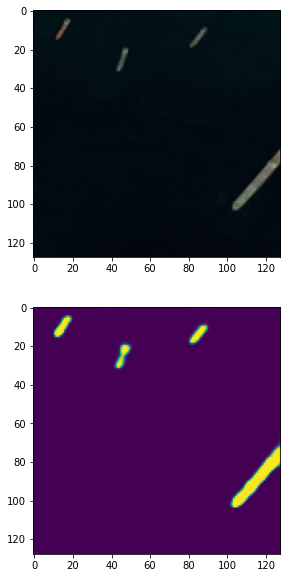

In [248]:
result = np.array(prediction.predictions)[0]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(result)

# In-Class Demo for Model Prediction Serve

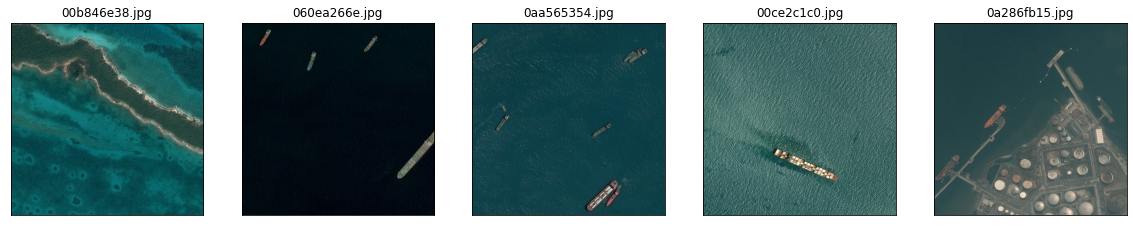

In [393]:
import numpy as np
import matplotlib.pyplot as plt
import google.cloud.aiplatform as aip
from google.cloud import storage
from io import BytesIO
from PIL import Image

aip.init(project=PROJECT_ID, location=REGION)
client = storage.Client() # Implicit environment set up
bucket = client.get_bucket('mle_airbus_dataset')
fname_list = ['00b846e38.jpg', '060ea266e.jpg', '0aa565354.jpg', '00ce2c1c0.jpg', '0a286fb15.jpg']
#fname_list = ['00f34434e.jpg', '0a8d5d261.jpg', '0a47fd117.jpg', '0ace4520c.jpg', '0afa92ce8.jpg']
img_ori_list = []

for fname in fname_list:
    blob = bucket.get_blob(f'train_v2/{fname}')
    img_big = Image.open(BytesIO(blob.download_as_bytes()))
    img_ori_list.append(img_big)
    

fig, axs = plt.subplots(1, len(fname_list), figsize=(20, 20))
for idx, image in enumerate(img_ori_list):
    axs[idx].imshow(image)
    axs[idx].set_xticklabels([])
    axs[idx].set_xticks([])
    axs[idx].set_yticklabels([])
    axs[idx].set_yticks([])
    axs[idx].set_title(fname_list[idx])

## Can you take a guess how the segmentation image will look like ?

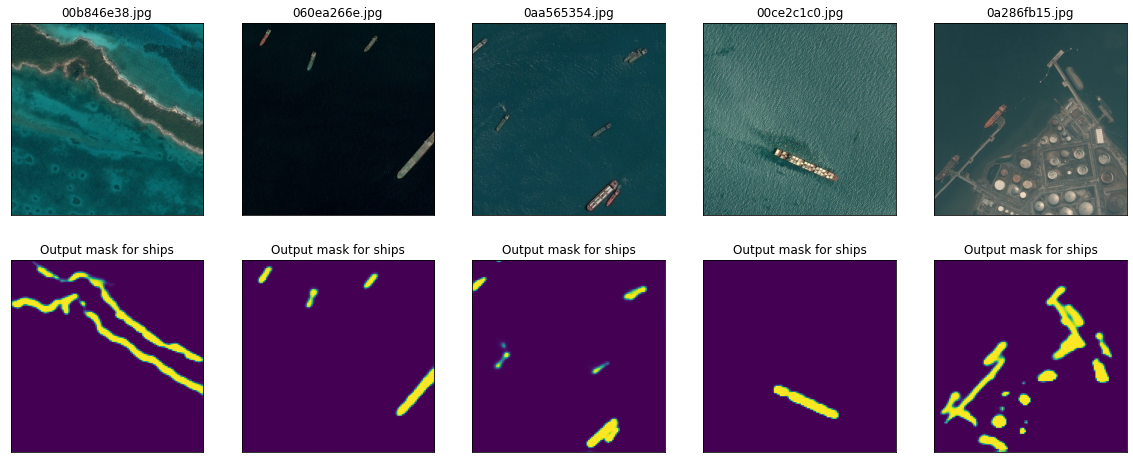

In [395]:
endpoint = aip.Endpoint(f'4643738981400313856') 

fig, axs = plt.subplots(2, len(fname_list), figsize=(20, 8))

for idx, image in enumerate(img_ori_list):

    img = image.resize((128, 128))
    input_img = (np.array(img.getdata())/255.0).reshape(128, 128, 3).tolist()
    prediction = endpoint.predict(instances=[input_img])
    result = np.array(prediction.predictions)[0]

    axs[0][idx].imshow(image)
    axs[0][idx].set_title(fname_list[idx])
    axs[1][idx].imshow(result)
    axs[1][idx].set_title('Output mask for ships')
    axs[0][idx].set_xticklabels([])
    axs[0][idx].set_xticks([])
    axs[0][idx].set_yticklabels([])
    axs[0][idx].set_yticks([])
    axs[1][idx].set_xticklabels([])
    axs[1][idx].set_xticks([])
    axs[1][idx].set_yticklabels([])
    axs[1][idx].set_yticks([])    